In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Data import get_format_data
from Data import get_format_data_without_na, get_rolling_average_data
from Data import get_normalize_data, normalize_data_additive, get_data_norm_flagged, get_gene_data, get_data_norm_flagged_2
import Data
from Data_analysis_func import plot_y2, plot_fv_fm_y2_linear_fit, variance_per_light_regime_y2, variance_per_plate_and_light_regime_y2, get_sample_fv_fm, range_per_plate_and_light_regime_y2
import Data_analysis_func
from Model_checks import plot_y2_distribution, plot_y2_normalized_distribution, normal_test, independence_test, same_variance_test, plot_cov, test_multivariate_gaussian, plot_mean_var_per_light_regime, plot_corr_per_light_regime, plot_distance_matrix
import Model_checks
import seaborn as sns
from Outlier_detection import mean_cov_y2_WT, compute_euclidian_distances, set_euclidian_distances_and_sigma, set_pvalues, set_euclidian_norm, set_log_likelihood_norm, set_sigma_norm, detect_outliers_log_likelihood, set_sigma_gene, detect_outliers_median, set_median_dev
from Genes_self_similarity import plot_genes_self_similarity, get_variance_for_genes, get_mean_var_WT, get_mean_intra_distance_for_genes, apply_flagging, calculate_distances_var, apply_flagging_2
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
import Outlier_detection_v2
import Outlier_detection

/Users/samsongourevitch/Documents/Chlamy_Project/venv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
data = get_format_data()

## Sanity checks

### Checking the evolution of $\frac{F_v}{F_m}$ to assess consistency of measurements over time

<AxesSubplot:title={'center':'Evolution of fv_fm Over Time (Daily Aggregation)'}, xlabel='Date', ylabel='fv_fm Value'>

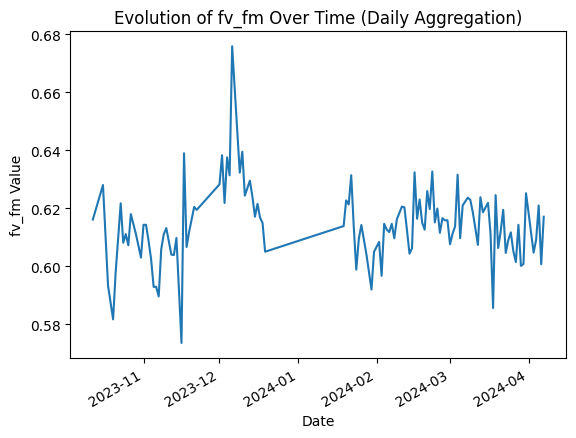

In [4]:
# Group by date and aggregate fv_fm values
daily_aggregated = data.groupby('start_date')['fv_fm'].mean()

# Plot the aggregated fv_fm values over time
daily_aggregated.plot(kind='line', xlabel='Date', ylabel='fv_fm Value', title='Evolution of fv_fm Over Time (Daily Aggregation)')


In [5]:
data_WT_not_99 = data[(data['mutant_ID'] == 'WT') & (data['plate'] != 99)]

<AxesSubplot:title={'center':'Evolution of WT fv_fm Over Time (Daily Aggregation)'}, xlabel='Date', ylabel='WT fv_fm Value'>

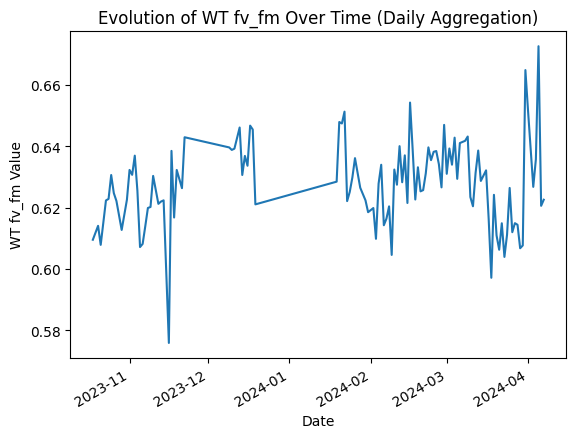

In [6]:
daily_aggregated_WT = data_WT_not_99.groupby('start_date')['fv_fm'].mean()


daily_aggregated_WT.plot(kind='line', xlabel='Date', ylabel='WT fv_fm Value', title='Evolution of WT fv_fm Over Time (Daily Aggregation)')

### Checking the distribution of $\frac{F_v}{F_m}$ in the WT plate

In [7]:
data_WT = data[data['mutant_ID'] == 'WT']

In [8]:
data_WT['measurement'].value_counts()

M1    825
M5    819
M4    444
M2    444
M6    441
M3    438
Name: measurement, dtype: int64

In [10]:
data_WT_without_M6 = data_WT[data_WT['measurement'] != 'M6']

In [14]:
data_WT_without_M6['mean_y2'].mean()

0.34466307663898277

In [11]:
data_WT_M6 = data_WT[data_WT['measurement'] == 'M6']

In [15]:
data_WT_M6['mean_y2'].mean()

0.4017425894836726

(array([  2.,   5.,  13.,  34., 125., 297., 495., 607., 635., 438., 225.,
        103., 118., 117., 112.,  48.,  18.,   7.,   3.,   1.]),
 array([0.56571305, 0.5736879 , 0.58166283, 0.5896377 , 0.59761256,
        0.6055875 , 0.61356235, 0.6215372 , 0.62951213, 0.637487  ,
        0.6454619 , 0.6534368 , 0.66141164, 0.66938657, 0.6773614 ,
        0.6853363 , 0.6933112 , 0.7012861 , 0.70926094, 0.71723586,
        0.7252107 ], dtype=float32),
 <BarContainer object of 20 artists>)

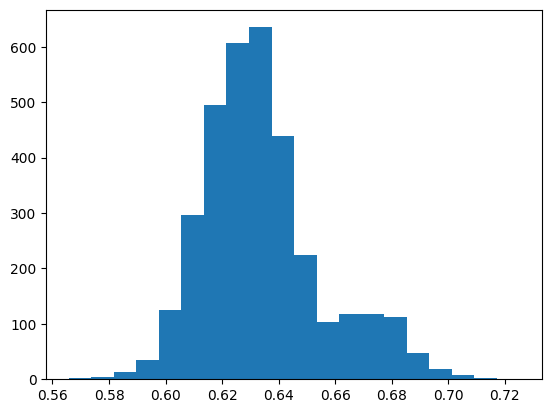

In [9]:
plt.hist(data_WT['fv_fm'], bins=20)

(array([  1.,   5.,   9.,  15.,  46., 132., 272., 413., 536., 536., 455.,
        271., 158.,  53.,  32.,  10.,   6.,   3.,   6.,   4.]),
 array([0.56571305, 0.57259953, 0.579486  , 0.5863725 , 0.593259  ,
        0.60014546, 0.60703194, 0.6139184 , 0.6208049 , 0.6276914 ,
        0.6345779 , 0.6414643 , 0.6483508 , 0.65523726, 0.66212374,
        0.6690102 , 0.6758967 , 0.6827832 , 0.68966967, 0.69655615,
        0.70344263], dtype=float32),
 <BarContainer object of 20 artists>)

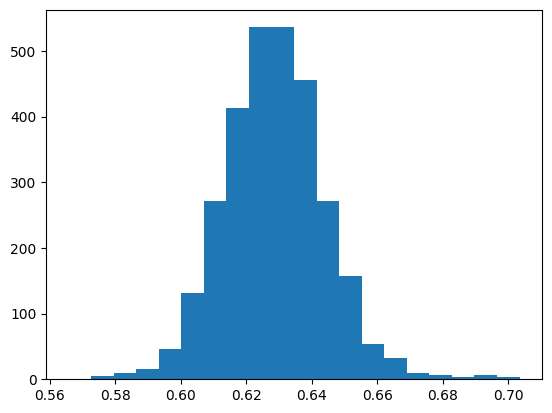

In [12]:
plt.hist(data_WT_without_M6['fv_fm'], bins=20)

<AxesSubplot:title={'center':'Average WT fv_fm Value by Measurement Type'}, xlabel='Measurement Type', ylabel='WT fv_fm Value'>

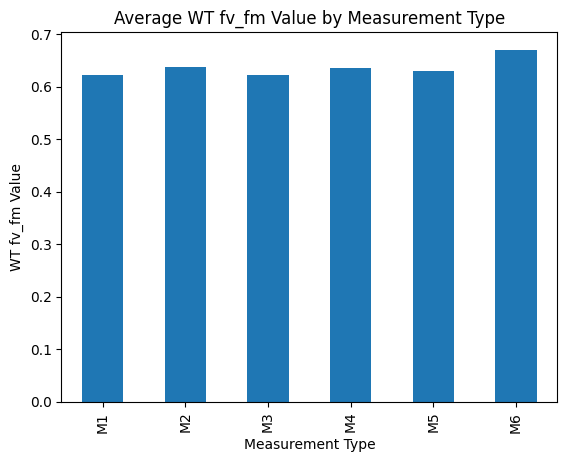

In [13]:
# Group by measurement type

data_grouped_WT = data_WT.groupby('measurement')['fv_fm'].mean()
data_grouped_WT.plot(kind='bar', xlabel='Measurement Type', ylabel='WT fv_fm Value', title='Average WT fv_fm Value by Measurement Type')

In [ ]:
data_WT_without_M6

,plate,measurement,start_date,light_regime,dark_threshold,light_threshold,num_frames,i,j,fv_fm,mask_area,y2_1,y2_2,y2_3,y2_4,y2_5,y2_6,y2_7,y2_8,y2_9,y2_10,y2_11,y2_12,y2_13,y2_14,y2_15,y2_16,y2_17,y2_18,y2_19,y2_20,y2_21,y2_22,y2_23,y2_24,y2_25,y2_26,y2_27,y2_28,y2_29,y2_30,y2_31,y2_32,y2_33,y2_34,y2_35,y2_36,y2_37,y2_38,y2_39,y2_40,y2_41,y2_42,y2_43,y2_44,y2_45,y2_46,y2_47,y2_48,y2_49,y2_50,y2_51,y2_52,y2_53,y2_54,y2_55,y2_56,y2_57,y2_58,y2_59,y2_60,y2_61,y2_62,y2_63,y2_64,y2_65,y2_66,y2_67,y2_68,y2_69,y2_70,y2_71,y2_72,y2_73,y2_74,y2_75,y2_76,y2_77,y2_78,y2_79,y2_80,npq_1,npq_2,npq_3,npq_4,npq_5,npq_6,npq_7,npq_8,npq_9,npq_10,npq_11,npq_12,npq_13,npq_14,npq_15,npq_16,npq_17,npq_18,npq_19,npq_20,npq_21,npq_22,npq_23,npq_24,npq_25,npq_26,npq_27,npq_28,npq_29,npq_30,npq_31,npq_32,npq_33,npq_34,npq_35,npq_36,npq_37,npq_38,npq_39,npq_40,npq_41,npq_42,npq_43,npq_44,npq_45,npq_46,npq_47,npq_48,npq_49,npq_50,npq_51,npq_52,npq_53,npq_54,npq_55,npq_56,npq_57,npq_58,npq_59,npq_60,npq_61,npq_62,npq_63,npq_64,npq_65,npq_66,npq_67,npq_68,npq_69,npq_70,npq_71,npq_72,npq_73,npq_74,npq_75,npq_76,npq_77,npq_78,npq_79,npq_80,npq_81,measurement_time_0,measurement_time_1,measurement_time_2,measurement_time_3,measurement_time_4,measurement_time_5,measurement_time_6,measurement_time_7,measurement_time_8,measurement_time_9,measurement_time_10,measurement_time_11,measurement_time_12,measurement_time_13,measurement_time_14,measurement_time_15,measurement_time_16,measurement_time_17,measurement_time_18,measurement_time_19,measurement_time_20,measurement_time_21,measurement_time_22,measurement_time_23,measurement_time_24,measurement_time_25,measurement_time_26,measurement_time_27,measurement_time_28,measurement_time_29,measurement_time_30,measurement_time_31,measurement_time_32,measurement_time_33,measurement_time_34,measurement_time_35,measurement_time_36,measurement_time_37,measurement_time_38,measurement_time_39,measurement_time_40,measurement_time_41,measurement_time_42,measurement_time_43,measurement_time_44,measurement_time_45,measurement_time_46,measurement_time_47,measurement_time_48,measurement_time_49,measurement_time_50,measurement_time_51,measurement_time_52,measurement_time_53,measurement_time_54,measurement_time_55,measurement_time_56,measurement_time_57,measurement_time_58,measurement_time_59,measurement_time_60,measurement_time_61,measurement_time_62,measurement_time_63,measurement_time_64,measurement_time_65,measurement_time_66,measurement_time_67,measurement_time_68,measurement_time_69,measurement_time_70,measurement_time_71,measurement_time_72,measurement_time_73,measurement_time_74,measurement_time_75,measurement_time_76,measurement_time_77,measurement_time_78,measurement_time_79,measurement_time_80,measurement_time_81,well_id,mutant_ID,feature,mutated_genes,num_mutations,fv_fm_end,well_id_numeric,mean_y2,median,log_likelihood_null
0,99,M1,2023-10-12,1min-1min,17.256280,25.025596,164,0,1,0.616175,23,0.270270,0.533629,0.232751,0.540770,0.224162,0.529528,0.193878,0.538035,0.242628,0.510312,0.205070,0.511599,0.215135,0.527934,0.218924,0.499973,0.224835,0.515611,0.211808,0.496580,0.218235,0.500721,0.212378,0.539128,0.240376,0.514455,0.254582,0.518713,0.232105,0.497286,0.222474,0.515025,0.238195,0.520012,0.169932,0.532556,0.224727,0.515576,0.186773,0.513873,0.193020,0.519921,0.243008,0.503751,0.214277,0.518877,0.147935,0.516192,0.235682,0.525710,0.203842,0.519636,0.212250,0.517520,0.243919,0.501261,0.199468,0.501736,0.228932,0.485910,0.228247,0.511375,0.178478,0.493264,0.188592,0.515792,0.169675,0.501365,0.214988,0.512785,0.196634,0.522091,0.194763,0.508460,0.191485,0.494745,0.215750,0.490876,0.226005,0.486919,0.710177,0.459191,0.768733,0.465228,0.804869,0.502006,0.852330,0.531314,0.810887,0.559744,0.905339,0.582623,0.855869,0.548937,0.835481,0.586495,0.860186,0.548005,0.860786,0.615712,0.885194,0.609652,0.874411,0.556295,0.832722,0.541172,0.827347,0.553080,0.821656,0.563349,0.835354,0.575884,0.811904,0.569682,0.880189,0.521956,0.781663

(array([  1.,   3.,   9.,  52., 155., 140.,  52.,  18.,   6.,   9.,   3.,
          1.,   1.,   0.,   1.,  19., 127., 353., 373., 408., 455., 365.,
        247., 102.,  40.,  14.,   7.,   0.,   1.,   1.]),
 array([0.09925545, 0.11310312, 0.12695079, 0.14079846, 0.15464613,
        0.1684938 , 0.18234147, 0.19618914, 0.21003681, 0.22388448,
        0.23773215, 0.25157982, 0.26542749, 0.27927516, 0.29312283,
        0.3069705 , 0.32081817, 0.33466583, 0.3485135 , 0.36236117,
        0.37620884, 0.39005651, 0.40390418, 0.41775185, 0.43159952,
        0.44544719, 0.45929486, 0.47314253, 0.4869902 , 0.50083787,
        0.51468554]),
 <BarContainer object of 30 artists>)

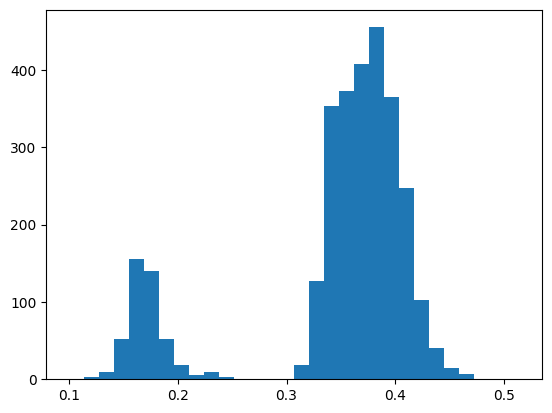

In [ ]:
plt.hist(data_WT_without_M6['mean_y2'], bins=30)

### Checking the variability of $\frac{F_v}{F_m}$ over the plates and measurement types

In [ ]:
data_not_WT = data[data['mutant_ID'] != 'WT']

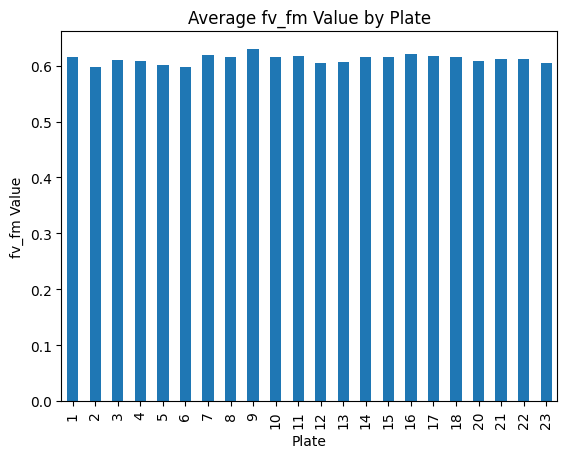

In [ ]:
# Check the variability between plates
data_grouped_plate = data_not_WT.groupby('plate')['fv_fm'].mean()
data_grouped_plate.plot(kind='bar', xlabel='Plate', ylabel='fv_fm Value', title='Average fv_fm Value by Plate')

mean, var = data_grouped_plate.mean(), data_grouped_plate.var()

In [ ]:
print('Mean:', mean)
print('Variance:', var)

Mean: 0.61200047
Variance: 5.8579102e-05


<AxesSubplot:title={'center':'Average WT fv_fm Value by Measurement Type (Plate 99)'}, xlabel='Measurement Type', ylabel='WT fv_fm Value'>

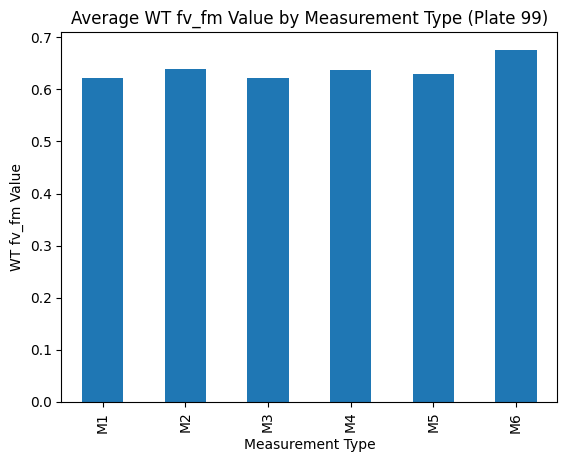

In [ ]:
data_WT_99 = data_WT[data_WT['plate'] == 99]
data_grouped_WT_99 = data_WT_99.groupby('measurement')['fv_fm'].mean()
data_grouped_WT_99.plot(kind='bar', xlabel='Measurement Type', ylabel='WT fv_fm Value', title='Average WT fv_fm Value by Measurement Type (Plate 99)')

In [ ]:
mean_WT, var_WT = data_WT['fv_fm'].mean(), data_WT['fv_fm'].var()

print('Mean (Plate 99):', mean_WT)
print('Variance (Plate 99):', var_WT)

Mean (Plate 99): 0.63398755
Variance (Plate 99): 0.00045195586


### Checking how many genes are present in different plates and looking at the variability

In [7]:
# Find the mutated genes that appear in multiple plates
multiple_plates_genes = []
for gene in data['mutated_genes'].unique():
    if len(data[data['mutated_genes'] == gene]['plate'].unique()) > 1:
        multiple_plates_genes.append(gene)

In [8]:
print('There are', len(multiple_plates_genes), 'different mutated genes that appear in multiple plates.')

There are 2242 different mutated genes that appear in multiple plates.


In [ ]:
gene = multiple_plates_genes[0]
data_gene = data[data['mutated_genes'] == gene]

In [ ]:
df_features = pd.DataFrame(columns=['gene', 'plate', 'light_regime', 'Mean', 'Standard Deviation', 'Max', 'Min'])

for gene in multiple_plates_genes:
    data_gene = data[data['mutated_genes'] == gene]
    for i, plate in enumerate(data_gene['plate'].unique()):
        data_gene_plate = data_gene[data_gene['plate'] == plate]
        for light_regime in data_gene_plate['light_regime'].unique():
            row = data_gene_plate[data_gene_plate['light_regime'] == light_regime].iloc[0]
            y2_values = row.filter(like='y2_').replace('Nan', np.nan).dropna()
            df = pd.DataFrame({'gene': [gene], 'plate': [plate], 'light_regime': [light_regime], 'Mean': [np.mean(y2_values)],
                            'Standard Deviation': [np.std(y2_values)], 'Max': [np.max(y2_values)],
                            'Min': [np.min(y2_values)]})
            df_features = pd.concat([df_features, df], ignore_index=True)

In [ ]:
df_features

,gene,plate,light_regime,Mean,Standard Deviation,Max,Min
0,,99,1min-1min,NaN,NaN,NaN,NaN
1,,99,20h_HL,0.212410,0.061501,0.554910,0.159874
...,...,...,...,...,...,...,...
22482,Cre03.g191800,17,2h-2h,0.321308,0.191957,0.529827,0.101807
22483,Cre03.g191800,17,10min-10min,0.284764,0.186798,0.501654,0.076312


In [ ]:
grouped_data = df_features.groupby(['gene', 'light_regime']).agg({'Mean': 'var', 'Standard Deviation': 'var', 'Max': 'var', 'Min': 'var'})

In [ ]:
grouped_data

Mean  Standard Deviation       Max       Min
gene          light_regime                                                  
              10min-10min   0.000499            0.000037  0.000756  0.000531
              1min-1min     0.000647            0.000029  0.000772  0.000929
...                              ...                 ...       ...       ...
Cre24.g755947 20h_ML        0.000990            0.000019  0.001781  0.001092
              2h-2h         0.000040            0.000121  0.000160  0.000304

[10101 rows x 4 columns]

### Checking the correlation between the position of the colony in the plate and the $\frac{F_v}{F_m}$ value

In [9]:
# Compute correlation coefficient
correlation = data['well_id_numeric'].corr(data['fv_fm'])

print("Correlation between well_id and fv_fm:", correlation)

Correlation between well_id and fv_fm: 0.05199088375628775


(array([2420., 2299., 2299., 2299., 2299., 2299., 2420., 2299., 2299.,
        2299., 2299., 2299., 2299., 2420., 2299., 2299., 2299., 2299.,
        2299., 2420.]),
 array([  0.  ,  19.15,  38.3 ,  57.45,  76.6 ,  95.75, 114.9 , 134.05,
        153.2 , 172.35, 191.5 , 210.65, 229.8 , 248.95, 268.1 , 287.25,
        306.4 , 325.55, 344.7 , 363.85, 383.  ]),
 <BarContainer object of 20 artists>)

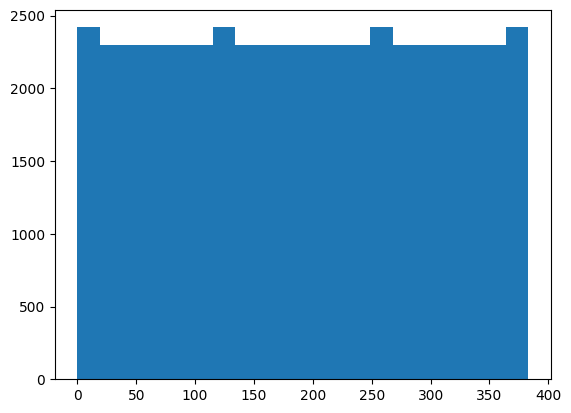

In [10]:
plt.hist(data['well_id_numeric'], bins=20)

In [17]:
correlation_WT_99 = data_WT_without_M6['well_id_numeric'].corr(data_WT_without_M6['fv_fm'])

In [18]:
print("Correlation between well_id of the WT and fv_fm for the plate 99:", correlation_WT_99)

Correlation between well_id of the WT and fv_fm for the plate 99: 0.2538056543816823


This is a little bit concerning, we may have to do another normalization step to correct for this.

### Check if the number of frames is consistent

(array([24960.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0., 21504.]),
 array([ 84.,  88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124.,
        128., 132., 136., 140., 144., 148., 152., 156., 160., 164.]),
 <BarContainer object of 20 artists>)

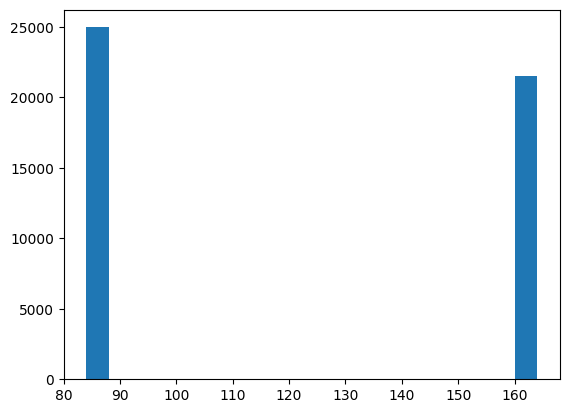

In [19]:
plt.hist(data['num_frames'], bins=20)

In [ ]:
# get the rows that have num_frames > 164

data_to_remake = data[(data['num_frames'] > 164)]

In [ ]:
data_to_remake['plate'].value_counts()

Series([], Name: plate, dtype: int64)

In [ ]:
data_to_remake

,plate,measurement,start_date,light_regime,dark_threshold,light_threshold,num_frames,i,j,fv_fm,mask_area,y2_1,y2_2,y2_3,y2_4,y2_5,y2_6,y2_7,y2_8,y2_9,y2_10,y2_11,y2_12,y2_13,y2_14,y2_15,y2_16,y2_17,y2_18,y2_19,y2_20,y2_21,y2_22,y2_23,y2_24,y2_25,y2_26,y2_27,y2_28,y2_29,y2_30,y2_31,y2_32,y2_33,y2_34,y2_35,y2_36,y2_37,y2_38,y2_39,y2_40,y2_41,y2_42,y2_43,y2_44,y2_45,y2_46,y2_47,y2_48,y2_49,y2_50,y2_51,y2_52,y2_53,y2_54,y2_55,y2_56,y2_57,y2_58,y2_59,y2_60,y2_61,y2_62,y2_63,y2_64,y2_65,y2_66,y2_67,y2_68,y2_69,y2_70,y2_71,y2_72,y2_73,y2_74,y2_75,y2_76,y2_77,y2_78,y2_79,y2_80,y2_81,npq_1,npq_2,npq_3,npq_4,npq_5,npq_6,npq_7,npq_8,npq_9,npq_10,npq_11,npq_12,npq_13,npq_14,npq_15,npq_16,npq_17,npq_18,npq_19,npq_20,npq_21,npq_22,npq_23,npq_24,npq_25,npq_26,npq_27,npq_28,npq_29,npq_30,npq_31,npq_32,npq_33,npq_34,npq_35,npq_36,npq_37,npq_38,npq_39,npq_40,npq_41,npq_42,npq_43,npq_44,npq_45,npq_46,npq_47,npq_48,npq_49,npq_50,npq_51,npq_52,npq_53,npq_54,npq_55,npq_56,npq_57,npq_58,npq_59,npq_60,npq_61,npq_62,npq_63,npq_64,npq_65,npq_66,npq_67,npq_68,npq_69,npq_70,npq_71,npq_72,npq_73,npq_74,npq_75,npq_76,npq_77,npq_78,npq_79,npq_80,npq_81,measurement_time_0,measurement_time_1,measurement_time_2,measurement_time_3,measurement_time_4,measurement_time_5,measurement_time_6,measurement_time_7,measurement_time_8,measurement_time_9,measurement_time_10,measurement_time_11,measurement_time_12,measurement_time_13,measurement_time_14,measurement_time_15,measurement_time_16,measurement_time_17,measurement_time_18,measurement_time_19,measurement_time_20,measurement_time_21,measurement_time_22,measurement_time_23,measurement_time_24,measurement_time_25,measurement_time_26,measurement_time_27,measurement_time_28,measurement_time_29,measurement_time_30,measurement_time_31,measurement_time_32,measurement_time_33,measurement_time_34,measurement_time_35,measurement_time_36,measurement_time_37,measurement_time_38,measurement_time_39,measurement_time_40,measurement_time_41,measurement_time_42,measurement_time_43,measurement_time_44,measurement_time_45,measurement_time_46,measurement_time_47,measurement_time_48,measurement_time_49,measurement_time_50,measurement_time_51,measurement_time_52,measurement_time_53,measurement_time_54,measurement_time_55,measurement_time_56,measurement_time_57,measurement_time_58,measurement_time_59,measurement_time_60,measurement_time_61,measurement_time_62,measurement_time_63,measurement_time_64,measurement_time_65,measurement_time_66,measurement_time_67,measurement_time_68,measurement_time_69,measurement_time_70,measurement_time_71,measurement_time_72,measurement_time_73,measurement_time_74,measurement_time_75,measurement_time_76,measurement_time_77,measurement_time_78,measurement_time_79,measurement_time_80,measurement_time_81,well_id,mutant_ID,feature,mutated_genes,num_mutations


### Check the number of Nan values in the dataset

In [20]:
data164frames = data[data['num_frames'] == 164]
# count the fraction of row that have a NaN value in one of the y2 columns
fraction_NaN_164frames = data164frames.filter(like='y2_').isna().any(axis=1).sum() / len(data164frames)
print('There are ', 100*fraction_NaN_164frames, '% of time-series with NaN values in the y2 columns for 164 frames')

There are  7.314918154761904 % of time-series with NaN values in the y2 columns for 164 frames


In [21]:
data84frames = data[data['num_frames'] == 84]
# count the fraction of row that have a NaN value in one of the y2 columns before y2_41
fraction_NaN_84frames = data84frames.filter(like='y2_').iloc[:, :40].isna().any(axis=1).sum() / len(data84frames)
print('There are ', 100*fraction_NaN_84frames, '% of time-series with NaN values in the y2 columns before y2_41 for 84 frames')

There are  7.756410256410256 % of time-series with NaN values in the y2 columns before y2_41 for 84 frames


### Check the number of plate 

In [22]:
data['plate'].value_counts()/384

99    8.0
15    6.0
23    6.0
5     6.0
22    6.0
18    6.0
11    6.0
8     6.0
16    6.0
14    6.0
1     5.0
21    5.0
17    5.0
13    5.0
10    5.0
9     5.0
7     5.0
4     5.0
3     5.0
2     4.0
12    4.0
6     4.0
20    2.0
Name: plate, dtype: float64

### Check if the fv_fm values are not the same between to consecutive days

In [ ]:
# Check if the fv_fm values are not the same between to consecutive days

99    12.0
18     6.0
8      6.0
5      6.0
7      6.0
      ... 
14     4.0
3      4.0
2      3.0
12     3.0
4      3.0
Name: plate, Length: 18, dtype: float64

### Check if there are some negative values in the y2 data

In [23]:
# Check if there are some negative values in the y2 data
data.filter(like='y2_').lt(0).sum().sum()

1482

In [24]:
# get the rows that have negative values in the y2 data
negative_rows = data[data.filter(like='y2_').lt(0).any(axis=1)]
negative_rows

,plate,measurement,start_date,light_regime,dark_threshold,light_threshold,num_frames,i,j,fv_fm,...,well_id,mutant_ID,feature,mutated_genes,num_mutations,fv_fm_end,well_id_numeric,mean_y2,median,log_likelihood_null
770,2,M1,2023-10-18,1min-1min,17.607635,25.893194,164,0,2,0.547058,...,A03,LMJ.RY0402.071251,MULTIPLE_SPLICE_VARIANTS,"Cre11.g479350,Cre07.g343933",2.0,0.489591,2,0.299502,None,None
963,2,M1,2023-10-18,1min-1min,17.607635,25.893194,164,8,3,0.436100,...,I04,LMJ.RY0402.063672,"3'UTR,CDS",Cre02.g146750,1.0,0.396992,195,0.200067,None,None
1056,2,M1,2023-10-18,1min-1min,17.607635,25.893194,164,12,0,0.568147,...,M01,LMJ.RY0402.061439,intron,Cre12.g528250,1.0,0.48913,288,0.303976,None,None
1104,2,M1,2023-10-18,1min-1min,17.607635,25.893194,164,14,0,0.672342,...,O01,LMJ.RY0402.063493,CDS,Cre12.g516450,1.0,0.559224,336,0.354824,None,None
1142,2,M1,2023-10-18,1min-1min,17.607635,25.893194,164,15,14,0.600734,...,P15,LMJ.RY0402.072442,intron,Cre06.g303751,1.0,0.673159,374,0.379487,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46220,20,M2,2024-04-07,20h_HL,15.370542,25.490716,84,5,20,0.574723,...,F21,LMJ.RY0402.062276,"intron,CDS",Cre12.g510350,1.0,0.360055,140,0.040806,None,None
46222,20,M2,2024-04-07,20h_HL,15.370542,25.490716,84,5,22,0.582876,...,F23,LMJ.RY0402.062258,"MULTIPLE_SPLICE_VARIANTS,-",Cre12.g550800,1.0,0.418413,142,0.053917,None,None
46254,20,M2,2024-04-07,20h_HL,15.370542,25.490716,84,7,6,0.515702,...,H07,LMJ.RY0402.070753,intron,Cre12.g542250,1.0,0.37664,174,0.059814,None,None
46367,20,M2,2024-04-07,20h_HL,15.370542,25.490716,84,11,23,0.647076,...,L24,LMJ.RY0402.098018,intron,Cre01.g023750,1.0,0.435191,287,0.124314,None,None


At this point, we have checked that the data is consistent and that there are no major issues with it. We can now proceed to the analysis. In order to do so, we first remove the Nan values and the anomalies in the data, that we have identified in the previous steps.

In [ ]:
# Remove the rows that have an anomaly in their number of frames or fv_fm values
data = data[data['num_frames'] <= 164]
data = data.dropna(subset=['fv_fm'])

data_WT = data[data['plate'] == 99]
data_not_WT = data[data['plate'] != 99]
data_1min = data[data['light_regime'] == '1min-1min']
data_ML = data[data['light_regime'] == '20h_ML']
data_HL = data[data['light_regime'] == '20h_HL']
data_30s = data[data['light_regime'] == '30s-30s']
data_2h = data[data['light_regime'] == '2h-2h']
data_10min = data[data['light_regime'] == '10min-10min']